In [1]:
############################################
# Team : RAGrats
# Team Members : Ali Asgar Padaria, Param Patel, Meet Zalavadiya
# 
# Code Description : This file contains the code for the Training the Roberta Classifier model.
#                    This trained model will be used as the classifer model for all the systems, baselines and improvements
#                    in the project. It is trained on the train set (18000 samples) and validated on the validation set (2000 samples).
#                    The model is trained for 3 epochs with input as (question, long_answer) pair and output as the class label (yes, no).
#                    The model is trained using AdamW optimizer with a learning rate of 2e-5, weight_decay of 0.001 and batch size of 16.
#                   
# NLP Concepts Usage: Tokenization, Embeddings, Language Modeling, Question Answering
#
# System : GCP Server L4 GPU
#############################################

In [ ]:
# Import Necessary Libraries

import torch
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    AutoConfig,
    AutoModel,
)
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset, load_from_disk
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
# Loading Dataset Stuff

train_dataset = load_from_disk("../files/train_dataset")
validation_dataset = load_from_disk("../files/val_dataset")

# dataset # holds final dataset

In [22]:
# Load Model - Roberta-Base for Classification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=1,  # Yes, No
)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Preprocssing the Dataset

def preprocess_function(example):
    # Use only questions and long_answers, no context
    
    final_prompt = f"{example['question']}\n{example['long_answer']}"
    inputs = tokenizer(     # NLP CONCEPT : Tokenization
        final_prompt,
        truncation=True,
        max_length=512
    )
    label_map = {"yes": 1, "no": 0} 
    inputs["labels"] = label_map[example["final_decision"]]
    return inputs

def train_collator(batch):
    input_ids = pad_sequence(
        [torch.tensor(x['input_ids']) for x in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    attention_mask = pad_sequence(
        [torch.tensor(x['attention_mask']) for x in batch],
        batch_first=True,
        padding_value=0
    )
    labels = torch.tensor([x['labels'] for x in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Preprocess datasets
tokenized_datasets = train_dataset.map(
    preprocess_function,
    remove_columns=train_dataset.column_names  # Change to dataset.column_names
)

tokenized_val_dataset = validation_dataset.map(
    preprocess_function,
    remove_columns=validation_dataset.column_names  # Change to val_dataset.column_names
)

# Create dataloaders with custom collator
train_dataloader = DataLoader(
    tokenized_datasets,  
    shuffle=True,
    batch_size=16,
    collate_fn=train_collator
)
val_dataloader = DataLoader(
    tokenized_val_dataset, 
    batch_size=16,
    collate_fn=train_collator
)


In [ ]:
def evaluate_model(model, val_loader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float().unsqueeze(1)  # shape: [batch_size, 1]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # shape: [batch_size, 1]

            probs = torch.sigmoid(logits)  # convert logits to probabilities
            preds = (probs > 0.5).long()   # thresholding

            all_preds.extend(preds.cpu().numpy().flatten())   # flatten for sklearn
            all_labels.extend(labels.cpu().numpy().flatten())

            # NLP CONCEPT : Question Answering

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"Acc: {acc:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

    return acc, precision, recall, f1

In [ ]:

def finetune_roberta_classifier(model, train_loader, num_epochs, lr=2e-5, weight_decay=0.01, device="cuda"):
    """
    Function to fine-tune a RoBERTa model for classification
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()  # For multi-class classification
    batch_losses = []

    metrics_per_epoch = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_losses = []

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float().unsqueeze(1)

            # Change device_type to device.type
            with torch.autocast(device_type=device.type, dtype=torch.float16): 
                outputs = model(input_ids=input_ids, attention_mask=attention_mask) # NLP CONCEPT : Language Modeling
                logits = outputs.logits
                loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            epoch_losses.append(loss.item())

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Training loss: {avg_epoch_loss:.4f}")

        # evaluate on validation set
        acc, precision, recall, f1 = evaluate_model(model, val_dataloader, device=device)
        metrics_per_epoch.append({
            'epoch': epoch + 1,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    return model, batch_losses, metrics_per_epoch


In [26]:
model, batch_losses, metrics_per_epoch = finetune_roberta_classifier(
    model=model,
    train_loader=train_dataloader,
    num_epochs=3,
    lr=2e-5,
    weight_decay=0.001,
    device=device
)

Epoch 1/3


Training: 100%|██████████| 1125/1125 [01:44<00:00, 10.73it/s]


Training loss: 0.2392


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 18.91it/s]


Acc: 0.9535 | Prec: 0.9567 | Rec: 0.9500 | F1: 0.9533
Epoch 2/3


Training: 100%|██████████| 1125/1125 [01:45<00:00, 10.70it/s]


Training loss: 0.1269


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 18.79it/s]


Acc: 0.9545 | Prec: 0.9605 | Rec: 0.9480 | F1: 0.9542
Epoch 3/3


Training: 100%|██████████| 1125/1125 [01:44<00:00, 10.77it/s]


Training loss: 0.0841


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 18.80it/s]

Acc: 0.9655 | Prec: 0.9784 | Rec: 0.9520 | F1: 0.9650


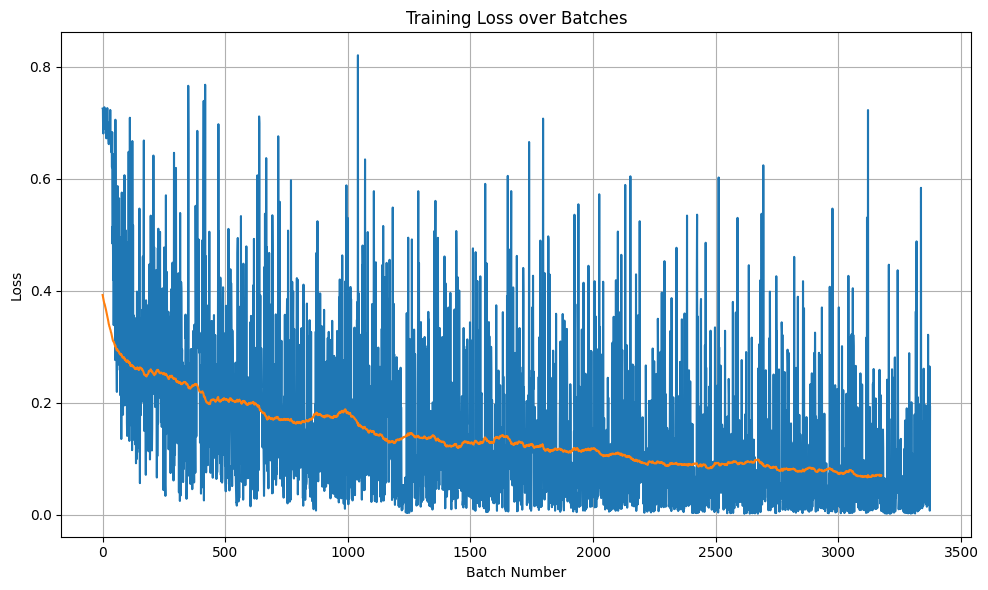

In [ ]:
# plot the training loss

def plot_batch_losses(batch_losses, num_epochs, batches_per_epoch, window_size=200):
    total_batches = num_epochs * batches_per_epoch
    losses_to_plot = batch_losses[:total_batches]

    smoothed_losses = np.convolve(losses_to_plot, np.ones(window_size)/window_size, mode='valid')


    plt.figure(figsize=(10, 6))
    plt.plot(range(total_batches), losses_to_plot)
    plt.plot(range(len(smoothed_losses)), smoothed_losses)

    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.title("Training Loss over Batches")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

batches_per_epoch = len(train_dataloader)
plot_batch_losses(batch_losses, num_epochs=3, batches_per_epoch=batches_per_epoch)

In [ ]:
# save the model for future access via models (baselines and improvements)
torch.save(model.state_dict(), "../files/roberta_classifier.pt")
